In [1]:
import os
import pathlib
import pandas as pd
from sklearn.metrics import classification_report
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [2]:
!pip install ktrain
import ktrain
from ktrain import text

     |████████████████████████████████| 25.3 MB 10.0 MB/s 
     |████████████████████████████████| 981 kB 69.2 MB/s 
     |████████████████████████████████| 136 kB 48.2 MB/s 
     |████████████████████████████████| 468 kB 45.4 MB/s 
  Created wheel for ktrain: filename=ktrain-0.41.3-py3-none-any.whl size=25316969 sha256=a8fe97237a9e7f8bff23f269a199b3a52e8e4b6163e14a998756683e8cf9621c
  Stored in directory: /root/.cache/pip/wheels/97/cd/a7/3ef9b6abdab10d64a111bac7f6f1cc4e9ea818c478335fb394
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=a91908193d9bd5a0db52e79f4dc43d1975523c98742cbe3fd8f1e35da1655c20
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
  Created wheel for tika: filename=tika-2.6.0-py3-none-any.whl size=32643 sha256=ab4084454d76dda38d4b0d0d137b1389c406d07f78f9a6281f5621b9bee20343
  Stored in directory: /root/.cache/pip/wheels/d0/e8/f2/4d6ee3cf46b79e22dcc7d4cdcbeed804c985d3

In [3]:
#check if the paths for the input data is valid.
train_path="../input/sentimentdatasets/trainJira.csv"
test_path="../input/sentimentdatasets/testJira.csv"
tr_path= pathlib.Path(train_path)
te_path=pathlib.Path(test_path)
if tr_path.exists ():
    print("Train data path set.")
else: 
    raise SystemExit("Train data path does not exist.")
     
if te_path.exists ():
    print("Test data path set.")
else: 
    raise SystemExit("Test data path does not exist.")
     

Train data path set.
Test data path set.


In [4]:
#showing the first 5 lines of the train data
train_df=pd.read_csv(train_path, encoding="utf-16", header=None)
train_df.head()


,0,1,2
0,409,I'm backporting this to 3.4 and 3.3 branches. ...,neutral
1,485,+1 overall. Here are the results of testing th...,neutral
2,611,Bug Flavio more? Seriously,negative
3,644,Integrated in ZooKeeper-trunk #1266 (See https...,neutral
4,927,The patch no longer applies. Abmar,neutral


In [5]:
#showing the first 5 lines of the test data
test_df=pd.read_csv(test_path, encoding="utf-16", header=None)
test_df[2]=test_df[2].astype(str)
test_df.head()


,0,1,2
0,180,neutral,Jimmy this ready for review/commit? If so plea...
1,2091,neutral,Edited these issues to set the fix version.
2,2685,neutral,Integrated in Hadoop-Mapreduce-trunk #1386 (Se...
3,2987,positive,Thanks for the patch
4,3399,neutral,Changed MULTI_TEXTVALUE_SEPARATOR into a prope...


In [6]:
print(type(train_df))

<class 'pandas.core.frame.DataFrame'>


In [7]:
x_train = train_df[1].values.tolist()
y_train = train_df[2].values.tolist()
x_test = test_df[2].values.tolist()
y_test = test_df[1].values.tolist()



In [8]:
# Preprocess the text data
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=x_train,
                                                                      y_train=y_train,
                                                                      x_test=x_test,
                                                                      y_test=y_test,
                                                                      maxlen=500,
                                                                      preprocess_mode='bert')

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [9]:
model = text.text_classifier('bert', (x_train, y_train) , preproc=preproc)

Is Multi-Label? False
maxlen is 500
done.


In [10]:
learner = ktrain.get_learner(model, 
                             train_data=(x_train, y_train), 
                             val_data=(x_test, y_test), 
                             batch_size=6)

In [11]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 4110 samples
Epoch 1/1024
4110/4110 [==============================] - 426s 104ms/sample - loss: 0.8121 - accuracy: 0.6246
Epoch 2/1024
2646/4110 [==================>...........] - ETA: 2:25 - loss: 1.0146 - accuracy: 0.6659

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


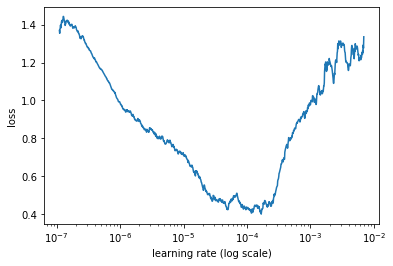

In [12]:
learner.lr_plot()

In [13]:
# 2e-5 is one of the LRs  recommended by Google and is consistent with the plot above.
learner.autofit(2e-5, early_stopping=5)

reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 2e-05...
Train on 4110 samples, validate on 1759 samples
Epoch 1/1024
4110/4110 [==============================] - 475s 115ms/sample - loss: 0.5082 - accuracy: 0.7995 - val_loss: 0.3205 - val_accuracy: 0.8806
Epoch 2/1024
4110/4110 [==============================] - 454s 110ms/sample - loss: 0.2754 - accuracy: 0.8968 - val_loss: 0.3208 - val_accuracy: 0.8806
Epoch 3/1024
4104/4110 [============================>.] - ETA: 0s - loss: 0.1934 - accuracy: 0.9276
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 1e-05 (if not early_stopping).
4110/4110 [==============================] - 456s 111ms/sample - loss: 0.1932 - accuracy: 0.9277 - val_loss: 0.3693 - val_accuracy: 0.8749
Epoch 4/1024
4110/4110 [==============================] - 457s 111ms/sample - loss: 0.1080 - accuracy: 0.9625 - val_loss: 0.4093 - val_accuracy: 0.8795
Epoch 5/1024
4104/4110 [=========

In [14]:
predictor = ktrain.get_predictor(learner.model,preproc=preproc)
predictor.save('model')

In [15]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [16]:
data=test_df[2].tolist()
label=test_df[1].tolist()

In [17]:
i=0
correct=0
wrong=0
total=len(data)
true_lab=[]
pred_lab=[]
text=[]
for dt in data:
    result=predictor.predict(dt)
    if not result== label[i]:
        text.append(dt)
        pred_lab.append(result)
        true_lab.append(label[i])
        wrong+=1
    else:
        correct+=1
    
    i+=1

name_dict = {
            'Name': text,
            'Gold Label' : true_lab,
            'Predicted Label': pred_lab
          }

wrong_data= pd.DataFrame(name_dict)

wrong_data.to_csv("wrong_results.csv", sep=';')   
    
    

In [18]:
names = ['negative', 'neutral', 'positive']
y_pred = predictor.predict(data)
y_true= test_df[1]
print(classification_report(y_true, y_pred, target_names=names))

              precision    recall  f1-score   support

    negative       0.82      0.74      0.78       235
     neutral       0.92      0.91      0.91      1186
    positive       0.80      0.89      0.84       338

    accuracy                           0.88      1759
   macro avg       0.85      0.85      0.84      1759
weighted avg       0.88      0.88      0.88      1759



In [19]:
print("Correct: ", correct,"/",total,"\nWrong: ", wrong,"/",total)

Correct:  1549 / 1759 
Wrong:  210 / 1759
